## import the required libraries

In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from sklearn.metrics import ndcg_score

## Reeading the Ground truth docs

In [50]:
# Function to read ground truth
def read_ground_truth(file_path):
    gt_data = pd.read_csv(file_path, sep='\t', header=None, names=['query', 'doc', 'rank'])
    return gt_data


## Reading The result for all stemmer from result directory

In [51]:
def read_results(result_directory):
    results = {}
    for filename in os.listdir(result_directory):
        if filename.endswith('.txt'):
            stemmer_name = filename[:-4]  # Remove .txt
            with open(os.path.join(result_directory, filename), 'r', encoding='utf-8') as f:
                lines = f.readlines()
                query_results = {}
                current_query = None
                
                for line in lines:
                    line = line.strip()
                    if line.startswith("Result for query"):
                        current_query = int(line.split()[-1])  # Get query number
                        query_results[current_query] = []
                    elif current_query is not None:
                        query_results[current_query].append(line)

            results[stemmer_name] = query_results
    return results

## The directory where result file placed run the code for reading the result

In [52]:
result_directory = 'I:/second paper data/IR_task_comparision/Stemmers_results'  # Change this to your results directory
ground_truth_path = 'I:/second paper data/IR_task_comparision/Ground_truth/ground_truth.txt'  # Change this to your ground truth file path

# Read data
ground_truth = read_ground_truth(ground_truth_path)
results = read_results(result_directory)

## Organizing the docs according to their relievance to queries

In [53]:
queries={}
gr_docs={}
count=0
rank={}
rank_per_doc={}
for q in ground_truth['query']:
    if q !="query no":
            q=int(q)
            
    if q in queries:
        q=int(q)
        queries[q].append([ground_truth['doc'][count],ground_truth['rank'][count]])
        
        gr_docs[q].append(ground_truth['doc'][count])
        rank[q].append(ground_truth['rank'][count])
        rank_per_doc[ground_truth['doc'][count]]=ground_truth['rank'][count]
        count=count+1
        
        
    else:
        if q !="query no":
            q=int(q)
            queries[q]=([ground_truth['doc'][count],ground_truth['rank'][count]])
            gr_docs[q]=[]
            gr_docs[q].append(ground_truth['doc'][count])
            rank[q]=[ground_truth['rank'][count]]
            rank_per_doc[ground_truth['doc'][count]]=ground_truth['rank'][count]
            count+=1
        

## Printing the results for percieasion, recall, F1 score

In [54]:
precision = {}
recall = {}
f1_score = {}
av_recall = {}
av_precision = {}
av_f1_score = {}

for stemmer, query in results.items():
    query_precisions = []  # Precision values for each query for this stemmer
    query_recalls = []     # Recall values for each query for this stemmer
    query_f1_scores = []   # F1 scores for each query for this stemmer

    for q in query:
        r = 0.0  # Count of relevant documents found
        t = 0.0  # Total documents retrieved so far

        for doc in results[stemmer][q]:
            doc = doc.strip()
            if doc in gr_docs[q]:  # Check if the document is relevant
                r += 1.0
            t += 1.0

        # Calculate precision and recall for the current query
        query_recall = r / len(gr_docs[q]) if len(gr_docs[q]) > 0 else 0.0
        query_precision = r / t if t > 0 else 0.0

        # Calculate F1 score for the current query
        if query_precision + query_recall > 0:
            query_f1 = 2 * (query_precision * query_recall) / (query_precision + query_recall)
        else:
            query_f1 = 0.0

        # Store results for each query
        query_recalls.append([q, query_recall])
        query_precisions.append([q, query_precision])
        query_f1_scores.append([q, query_f1])

    # Calculate the average precision, recall, and F1 score for this stemmer across all queries
    avg_precision = sum([p[1] for p in query_precisions]) / len(query_precisions)
    avg_recall = sum([r[1] for r in query_recalls]) / len(query_recalls)
    avg_f1 = sum([f[1] for f in query_f1_scores]) / len(query_f1_scores)

    # Store the results
    precision[stemmer] = query_precisions
    recall[stemmer] = query_recalls
    f1_score[stemmer] = query_f1_scores
    av_precision[stemmer] = avg_precision
    av_recall[stemmer] = avg_recall
    av_f1_score[stemmer] = avg_f1

#print("Precision per query:", precision)
#print("Recall per query:", recall)
#print("F1 Score per query:", f1_score)
print("Average Precision per stemmer:", av_precision)
#print("Average Recall per stemmer:", av_recall)
#print("Average F1 Score per stemmer:", av_f1_score)


Average Precision per stemmer: {'Cog stemmer': 0.5028571428571429, 'Farasa stemmer': 0.5771428571428571, 'Isri stemmer': 0.5428571428571429, 'Khoja stemmer': 0.22857142857142856, 'Light10 stemmer': 0.4971428571428572, 'Lucen stemmer': 0.21142857142857152, 'No stemming': 0.4857142857142857, 'Proposed Light': 0.5828571428571431, 'Proposed Root': 0.3999999999999999, 'Stop words removal': 0.4971428571428572, 'Tashaphyne stemmer': 0.52, 'Proposed Very_light': 0.542857142857143}


## plot the result

In [55]:
def plot_metrics(data,purpose):
    stemmers = list(data.keys())
    values = list(data.values())

    # Create a bar plot
    plt.figure(figsize=(12,6))
    plt.bar(stemmers, values, color='skyblue')  # Horizontal bar plot
    plt.xticks(rotation=45)
    # Add labels and title
    plt.xlabel('Stemmers')
    plt.ylabel('Scores')
    plt.title(purpose)

    # Show plot
    plt.tight_layout()
    plt.show()


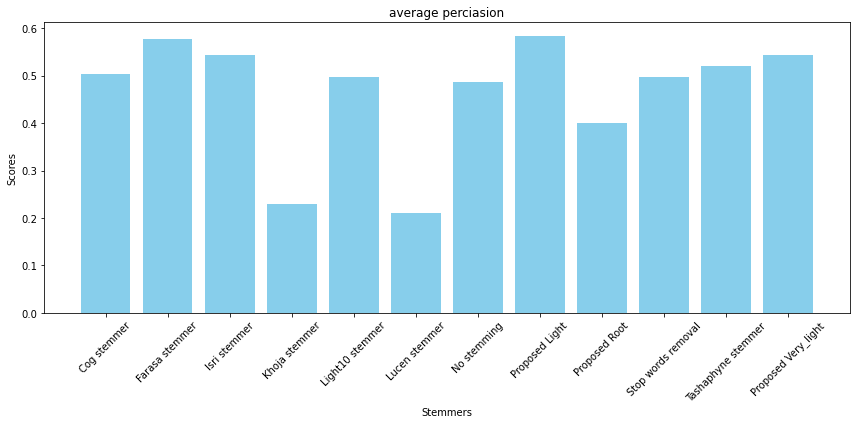

In [56]:
plot_metrics(av_precision,"average perciasion")

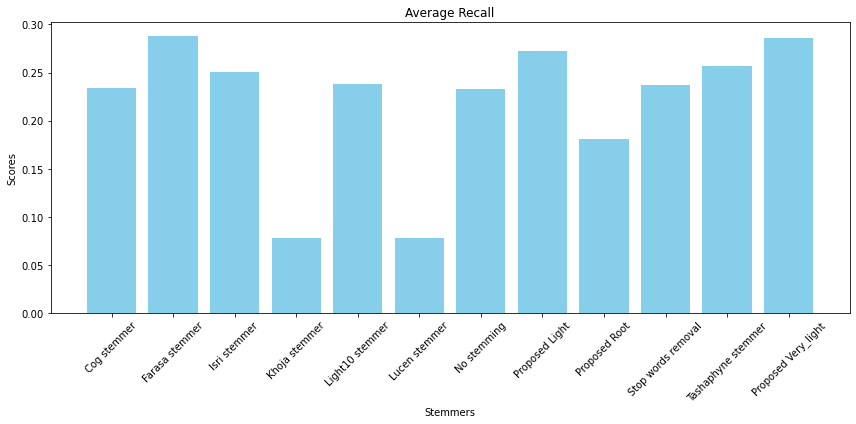

In [57]:
plot_metrics(av_recall,"Average Recall")

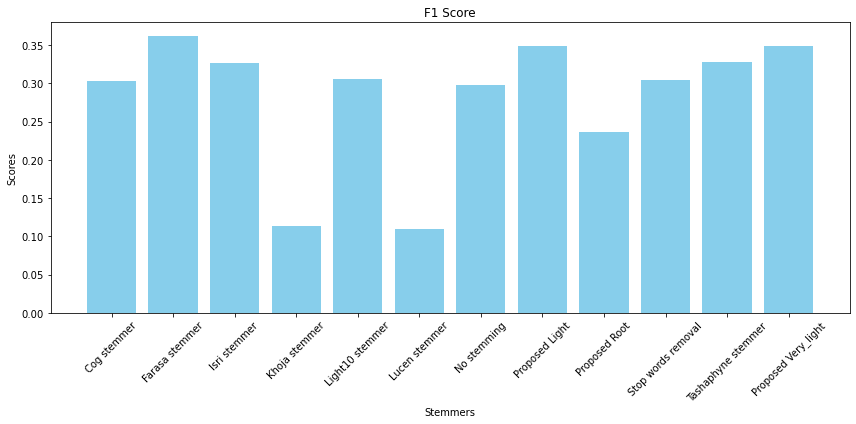

In [59]:
plot_metrics(av_f1_score,"F1 Score")

## printing the Map result

In [60]:
Map = {}
for stemmer, query in results.items():
    AP_sum = 0.0  # To store sum of AP for each query for a stemmer
    num_queries = len(query)  # Total number of queries

    for q in query:
        r = 0.0  # Number of relevant documents found so far
        t = 0.0  # Total documents considered so far
        ap = 0.0  # Average Precision for this query

        for doc in results[stemmer][q]:
            doc = doc.strip()
            t += 1.0
            if doc in gr_docs[q]:  # Check if the document is relevant
                r += 1.0
                ap += r / t  # Sum precision at each relevant document

        # Calculate AP for this query
        if r > 0:
            AP_sum += ap / r  # Average precision for the query
        else:
            AP_sum += 0.0  # No relevant documents, AP is zero for this query

    # Calculate MAP for the stemmer by averaging AP over all queries
    Map[stemmer] = AP_sum / num_queries

print(Map)


{'Cog stemmer': 0.723531746031746, 'Farasa stemmer': 0.7833333333333333, 'Isri stemmer': 0.7280952380952379, 'Khoja stemmer': 0.38626984126984126, 'Light10 stemmer': 0.6453174603174603, 'Lucen stemmer': 0.36801587301587296, 'No stemming': 0.6787301587301587, 'Proposed Light': 0.8623015873015872, 'Proposed Root': 0.6230555555555555, 'Stop words removal': 0.7015476190476191, 'Tashaphyne stemmer': 0.6942857142857142, 'Proposed Very_light': 0.8207142857142858}


## Plotting the map result

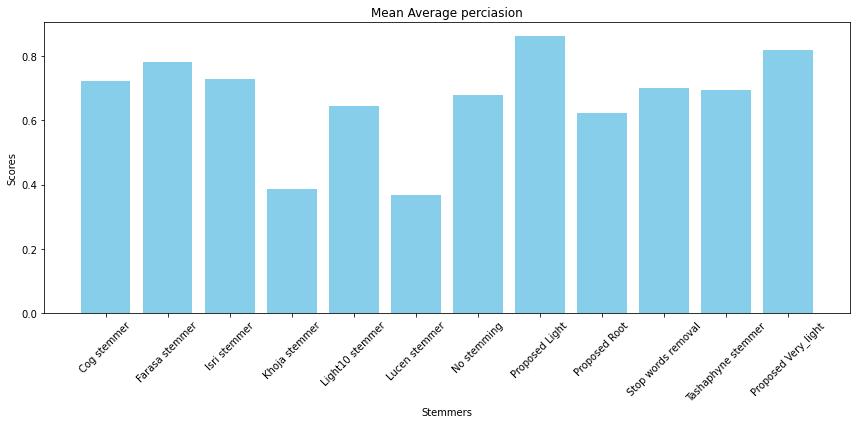

In [61]:
plot_metrics(Map,"Mean Average perciasion")